In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

In [3]:
import warnings
from arrow.factory import ArrowParseWarning

warnings.simplefilter("ignore", ArrowParseWarning)

In [4]:
import arrow
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from util.file_util import StockTwitsFileReader, StockDataFileReader
from util.ts_util import (
    shift_date_index, calc_corr, 
    resample_weekly, rolling_nday)
from util.plot_util import (
    plot_time_series_bar, overlay_on_secondary_axis)
from util.stockdata_helper import (
    get_sp500_sector_info, get_gics_sector_list,
    get_etf_ticker_for_sector, get_component_tickers_for_sector,
    get_nday_returns_for_ticker
)
from config import STOCKTWITS_TICKER_LIST, ETF_TICKER_TO_SECTOR

In [5]:
twit_file_reader = StockTwitsFileReader() 
stock_file_reader = StockDataFileReader()

In [6]:
start_date = '2017-01-01'
end_date = '2019-08-10'

In [7]:
all_sectors = get_gics_sector_list()
all_sectors

['Consumer Staples',
 'Real Estate',
 'Industrials',
 'Information Technology',
 'Energy',
 'Materials',
 'Consumer Discretionary',
 'Financials',
 'Health Care',
 'Utilities',
 'All']

In [8]:
def append_sentiment_cols(sentiment_df):
    new_sentiment_df = sentiment_df.copy()
    
    new_sentiment_df['Bullish_minus_Bearish'] = new_sentiment_df['Bullish'] - new_sentiment_df['Bearish']
    new_sentiment_df['Log_Bullish_over_Bearish'] = np.log(new_sentiment_df['Bullish']) - np.log(new_sentiment_df['Bearish'])
    return new_sentiment_df

def get_daily_sentiment_agg_df_for_sector(sector):
    tickers_in_sector = get_component_tickers_for_sector(sector)
    print('number of component tickers {} in {}'.format(len(tickers_in_sector),
                                                        sector))
    
    daily_sentiment_agg_df = pd.DataFrame()

    for ticker in tickers_in_sector:
        twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker,
                                                                       start_date=start_date,
                                                                       end_date=end_date)
        twit_df['Bullish_minus_Bearish'] = twit_df['Bullish'] - twit_df['Bearish']
        
        daily_sentiment_agg_df = daily_sentiment_agg_df.add(twit_df, fill_value=0)
    
    return daily_sentiment_agg_df

def get_daily_sentiment_df_dict_for_sector(sector):
    tickers_in_sector = get_component_tickers_for_sector(sector)
    print('number of component tickers {} in {}'.format(len(tickers_in_sector),
                                                        sector))
    
    daily_sentiment_df_dict = {}

    for ticker in tickers_in_sector:
        twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker,
                                                                       start_date=start_date,
                                                                       end_date=end_date)
        if len(twit_df):
            twit_df['Bullish_minus_Bearish'] = twit_df['Bullish'] - twit_df['Bearish']
        
        daily_sentiment_df_dict[ticker] = twit_df
    
    return daily_sentiment_df_dict

In [158]:
sector = 'Industrials'

In [159]:
daily_sentiment_agg_df = get_daily_sentiment_agg_df_for_sector(sector)
daily_sentiment_df_dict = get_daily_sentiment_df_dict_for_sector(sector)

number of component tickers 69 in Industrials
number of component tickers 69 in Industrials


In [160]:
etf_ticker = get_etf_ticker_for_sector(sector)
etf_price_df = stock_file_reader.read_stockdata_in_range(etf_ticker,
                                                         start_date, 
                                                         end_date)

Text(0.5, 0.98, 'Industrials')

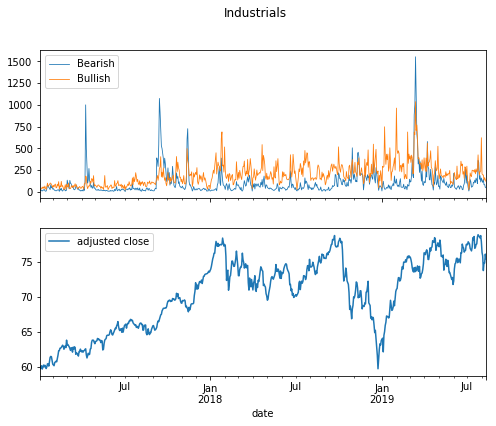

In [161]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

daily_sentiment_agg_df.plot(y=['Bearish', 'Bullish'],
                            linewidth=0.8,
                            ax=axes[0])
etf_price_df.plot(ax=axes[1])
plt.suptitle(sector)

In [162]:
etf_price_df['2018-03']

,adjusted close
date,
2018-03-01,72.9954
2018-03-02,72.9759
2018-03-05,73.8501
2018-03-06,74.1804
2018-03-07,74.1707
2018-03-08,74.5592
2018-03-09,76.2008
2018-03-12,75.2586
2018-03-13,74.8895


In [163]:
case_study_df = daily_sentiment_agg_df.sort_values('Bullish_minus_Bearish').head(5)
case_study_df

,Bearish,Bullish,Bullish_minus_Bearish
2017-04-11,999.0,181.0,-818.0
2017-09-14,1073.0,267.0,-806.0
2017-09-15,916.0,285.0,-631.0
2019-03-13,1552.0,1036.0,-516.0
2019-03-14,1083.0,705.0,-378.0


In [164]:
def get_field_stat_by_ticker(daily_sentiment_df_dict,
                             ref_date,
                             prev_n_days=1,
                             col_name='Bullish_minus_Bearish'):

    stat_by_ticker = {}

    for t in daily_sentiment_df_dict:
        try:
            if prev_n_days == 1:
                r = daily_sentiment_df_dict[t].loc[ref_date]
            else:
                prev_date = arrow.get(ref_date).shift(days=-1 * prev_n_days).strftime('%Y-%m-%d')
                r = daily_sentiment_df_dict[t].loc[prev_date:ref_date].sum()
            stat_by_ticker[t] = r['Bullish_minus_Bearish']
        except:
            continue
            
    return stat_by_ticker

In [165]:
bear_sentiment_ratio = [] 

for dt in pd.date_range(start_date, end_date):
    weekly_agg = get_field_stat_by_ticker(daily_sentiment_df_dict,
                             dt,
                             prev_n_days=7)
    weekly_agg = pd.Series(weekly_agg)
    n_companies_bear = weekly_agg[weekly_agg < -5].count()
    bear_sentiment_ratio.append({
        'date': dt,
        'n_companies_bear': n_companies_bear,
    })

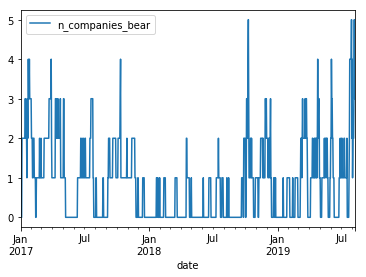

In [166]:
pd.DataFrame(bear_sentiment_ratio).set_index('date').plot()

In [167]:
weekly_agg.count()

69

In [135]:
get_field_stat_by_ticker(daily_sentiment_df_dict,
                         '2019-03-30',
                         prev_n_days=90)

{'AMG': 6.0,
 'AFL': 54.0,
 'ALL': 66.0,
 'AXP': 139.0,
 'AIG': 77.0,
 'AMP': 11.0,
 'AON': 16.0,
 'AJG': 6.0,
 'AIZ': -2.0,
 'BAC': 1424.0,
 'BK': 12.0,
 'BBT': 85.0,
 'BRK.B': 257.0,
 'BLK': 26.0,
 'COF': 81.0,
 'CBOE': 3.0,
 'SCHW': -1.0,
 'CB': 3.0,
 'CINF': 3.0,
 'C': 182.0,
 'CFG': 17.0,
 'CME': 93.0,
 'CMA': 0.0,
 'DFS': 96.0,
 'ETFC': 30.0,
 'RE': 1.0,
 'FITB': 28.0,
 'FRC': 0.0,
 'BEN': 3.0,
 'GS': 445.0,
 'HIG': 46.0,
 'HBAN': 57.0,
 'ICE': 4.0,
 'IVZ': 9.0,
 'JEF': 11.0,
 'JPM': 334.0,
 'KEY': 35.0,
 'LNC': 69.0,
 'L': 5.0,
 'MTB': 12.0,
 'MKTX': 3.0,
 'MMC': 9.0,
 'MET': 9.0,
 'MCO': 8.0,
 'MS': 111.0,
 'MSCI': 58.0,
 'NDAQ': 16.0,
 'NTRS': -4.0,
 'PBCT': 8.0,
 'PNC': 68.0,
 'PFG': 15.0,
 'PGR': 42.0,
 'PRU': 102.0,
 'RJF': 7.0,
 'RF': 79.0,
 'SPGI': 5.0,
 'STT': 81.0,
 'STI': 96.0,
 'SIVB': 28.0,
 'SYF': 97.0,
 'TROW': 7.0,
 'TRV': 74.0,
 'USB': 58.0,
 'UNM': 4.0,
 'WFC': 183.0,
 'WLTW': 6.0,
 'ZION': 15.0}

In [99]:
ticker = 'GS'

In [100]:
ref_date = '2017-04-10'
ref_prev_date = arrow.get(ref_date).shift(months=-1).strftime('%Y-%m-%d')
ref_next_date = arrow.get(ref_date).shift(months=1).strftime('%Y-%m-%d')

In [101]:
def plot_sentiment_and_price(sentiment_df, price_df,
                             title=''):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    sentiment_df.plot(y=['Bearish', 'Bullish'],
                     linewidth=0.8,
                     ax=axes[0])
    price_df.plot(ax=axes[1])
    plt.suptitle(title)

In [102]:
case_study_twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(
    ticker, start_date=start_date, end_date=end_date)

In [103]:
case_study_price_df = stock_file_reader.read_stockdata_in_range(ticker,
                                                                start_date,
                                                                end_date)

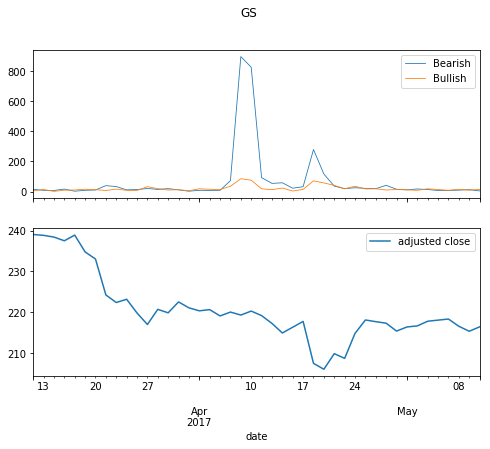

In [104]:
plot_sentiment_and_price(case_study_twit_df.loc[ref_prev_date:ref_next_date],
                         case_study_price_df.loc[ref_prev_date:ref_next_date],
                         title=ticker)

In [106]:
case_study_twit_df.loc['2017-04':]

,Bearish,Bullish
2017-04-03,8.0,18.0
2017-04-04,7.0,15.0
2017-04-05,8.0,13.0
2017-04-06,72.0,35.0
2017-04-07,897.0,85.0
2017-04-10,826.0,75.0
2017-04-11,92.0,18.0
2017-04-12,54.0,12.0
2017-04-13,58.0,23.0
2017-04-14,22.0,3.0


In [ ]:
merged = daily_sentiment_agg_df.merge(etf_price_df,
                                      how='left',
                                      left_index=True,
                                      right_index=True)

In [ ]:
merged.plot(secondary_y='adjusted close')

In [ ]:
etf_price_df.plot()

In [ ]:
daily_sentiment_agg_df['Bullish_minus_Bearish'] = daily_sentiment_agg_df['Bullish'] - daily_sentiment_agg_df['Bearish']

In [ ]:
daily_sentiment_agg_df.sort_values('Bullish_minus_Bearish').head(20)

In [ ]:
etf_ticker

In [ ]:
ref_date = '2017-04-07'

In [ ]:
stat_by_ticker = {}

for t in daily_sentiment_df_dict:
    try:
        r = daily_sentiment_df_dict[t].loc[ref_date]
        stat_by_ticker[t] = r['Bullish_minus_Bearish']
    except:
        continue

In [ ]:
stat_by_ticker

In [ ]:
ticker = 'GS'

In [ ]:
stock_price_df = stock_file_reader.read_stockdata_in_range(ticker,
                                                           start_date,
                                                           end_date)

In [ ]:
temp = twit_file_reader.read_twit_file_in_range(ticker,
                                                '2017-04-07', 
                                                '2017-04-07')

In [ ]:
daily_sentiment_df_dict[ticker].loc['2017-04':].head(10)

In [ ]:
stock_price_df.loc['2017-04-01':].head(15)

In [ ]:
# temp[temp['entities.sentiment.basic'] == 'Bullish']['body'].values

In [ ]:
stock_price_df.index

In [ ]:
temp[temp['entities.sentiment.basic']=='Bearish'].sample(20)['body'].values